An r-limited Delaunay graph implementation in python.

Formally, the r-lim Del is the intersection of an r-disc graph and the del-graph. We can find both of these (r-disc O(n^2), del-graph O(n log n)) in adj matrix form (0 if edge not there, 1 if edge there), then bitwise multiply the two :)

If we shift to using cells to minimize radius work, shift to adj lists or adj sets

Sources:
Neil the GOAT,
https://www.esaim-cocv.org/articles/cocv/pdf/2005/04/cocv0407.pdf,
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0192987

In [361]:
# imports
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

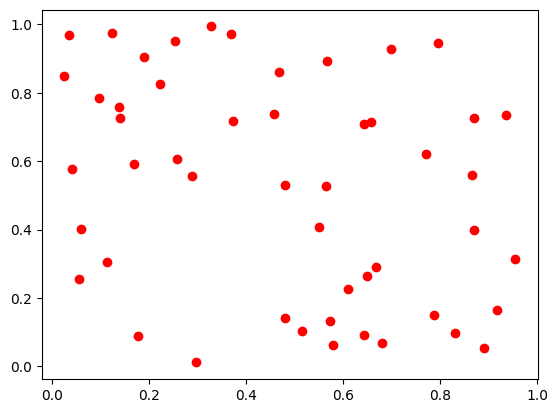

In [362]:
# generate point set to graph, sample is the five points from the paper with 2 edge removal cases, 
# rSample is a randomized set producing n points

n = 50
rng = np.random.default_rng()

# sample = np.array([[0,0],[0.45,0.4],[0.9,0.25],[0.95,1],[1.5,0.75]])
# P = sample

rSample = rng.random((n,2))
P = rSample

plt.plot(P[:,0], P[:,1], 'ro')

In [363]:
# make del-graph

# takes point set P, returns triset we can plot using plt.triplot
def delG(P):
    tri = Delaunay(P)
    return tri

# need to find a way to turn into adj matrix

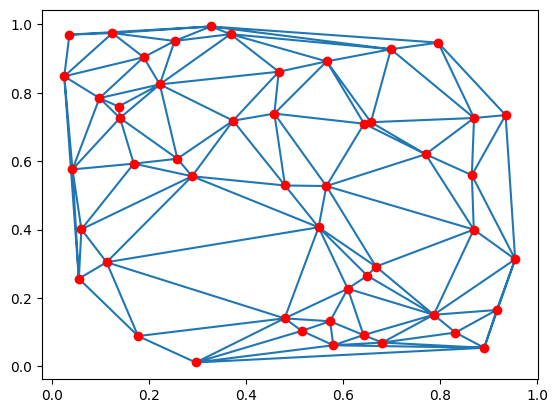

In [364]:
tris = delG(P)
plt.plot(P[:,0], P[:,1], 'ro')
plt.triplot(P[:,0], P[:,1], tris.simplices.copy())

In [365]:
# we will need a distance function for our r-graph function
def dist(a,b):
    return np.sqrt((b[1] - a[1])**2 + (b[0] - a[0])**2)

In [366]:
# make r-graph

# simple for loop checking each dist from each vertex to another, comparing to given radius
# takes radius r, and point set P
# returns list of edges (to plot) and an adj matrix representation of the r-limited graph
def rGraph(r, P):
    # make adj matrix init to all 0s
    adjMat = np.zeros((P.shape[0],P.shape[0]))
    # make edges a list
    edges = list()
    for i in range(adjMat.shape[0]):
        for j in range(adjMat.shape[1]):
            # check dist between points
            if (dist(P[i],P[j]) <= r):
                # update adjMat and add edge to list
                adjMat[i,j] = 1 
                edges.append((i,j))
    return adjMat, np.array(edges)

r = 0.2
adjMat, m_edges = rGraph(r, P)
print(adjMat)
print(m_edges.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(290, 2)


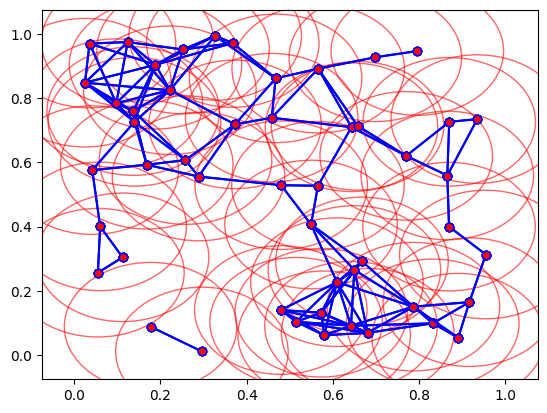

In [387]:
fig, ax = plt.subplots()
for i in range(P.shape[0]-4):
        ax.add_patch(plt.Circle((P[i][0], P[i][1]), r, color='r', fill=False, alpha=0.6))
ax.set_xlim([-0.075,1.075])
ax.set_ylim([-0.075,1.075])

# graph
plt.plot(P[:,0][m_edges.T], P[:,1][m_edges.T], linestyle='-', color='b',
        markerfacecolor='red', marker='o')
plt.show()

This removes one illegal edge from the the original graph, however we need to remove edges between points who don't have an edge intersect with the r/2 radius or have a closest vertice in the voronoi thats not within the r/2 radius

These graphs make it clear that the intersection of the r-limited graph and the Delaunay graph will not be enough to give us the r-limited Delaunay graph. Looking back over the paper, this makes some sense as the paper uses a voronoi r/2-limited graph to excludes edges in the voronoi whos cell intersections (the edge between two voronoi cells) are outside the radius.

To achieve this, we will be performing two steps. For each point, we will go over its neighbors (planar graph, O(n)?). First we check whether a line of magnitude r/2 pointing from the point to its neighbor intersects with the "ridge line" (cell edge) between the cells. If it does, include the edge between these points. If the lines do not intersect, that means the edge between the points goes over another cell. Second we check whether the distance from a point to the closest voronoi ridge vertex (closest endpoint of ridge line) connecting the voroni regions these points lie is less than or equal to the radius of our agent. If not, exclude this edge.

In [368]:
# def r2Vor(P, r):
    # find vor

    # for each point
        # find neighbors in vor
        # for each neighbor in vor
            # find vor edge between points

            # check if line segment from point i to point j with magnitude of r/2
            # intersects the ridge line between points i,j

            # if they do intersect, keep the edge
            # if they don't, check closest ridge vert
                # if it lies within r, keep edge
                # else remove
    # return

To implement this, we will need an efficient way to find the ridge between voronoi sources (our points)

In [369]:
# import voronoi from scipy
from scipy.spatial import Voronoi, voronoi_plot_2d

(137, 2)
[[-1, 15], [15, 17], [16, 17], [-1, 16], [2, 15], [2, 8], [-1, 7], [7, 8], [2, 5], [4, 5], [4, 12], [12, 17], [18, 19], [18, 20], [19, 21], [20, 21], [3, 4], [3, 22], [11, 12], [11, 18], [19, 26], [22, 26], [14, 21], [14, 25], [25, 26], [3, 9], [5, 28], [9, 10], [10, 27], [27, 28], [8, 29], [28, 29], [9, 33], [10, 30], [30, 32], [32, 36], [33, 36], [22, 34], [33, 34], [23, 35], [23, 24], [24, 25], [34, 35], [35, 38], [36, 37], [37, 38], [13, 14], [13, 40], [24, 39], [39, 40], [39, 42], [40, 41], [41, 43], [42, 43], [-1, 41], [-1, 44], [43, 44], [-1, 1], [1, 45], [16, 46], [45, 46], [48, 51], [48, 50], [49, 50], [49, 53], [51, 52], [52, 53], [27, 51], [29, 48], [6, 50], [6, 7], [31, 53], [31, 49], [30, 52], [0, 54], [-1, 0], [-1, 54], [44, 55], [-1, 56], [55, 56], [57, 60], [57, 58], [58, 59], [59, 61], [60, 61], [23, 57], [38, 60], [42, 58], [55, 59], [62, 63], [62, 64], [63, 65], [64, 65], [-1, 64], [13, 62], [66, 70], [66, 67], [67, 68], [68, 69], [69, 70], [11, 67], [20, 47

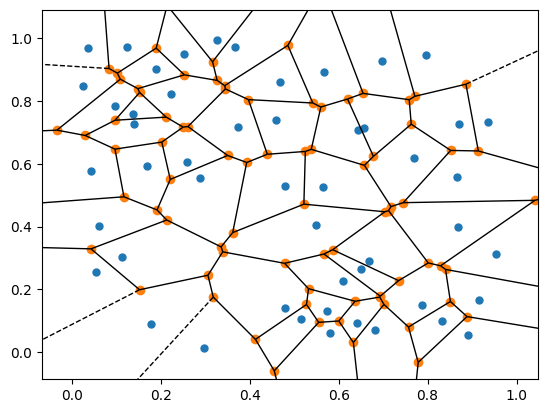

In [370]:
# just to demonstrate the difference and difficulties without a bounding box

vor = Voronoi(P)
fig = voronoi_plot_2d(vor, point_size=10)

print(vor.ridge_points.shape)
print(vor.ridge_vertices)

# the graph isn't well centered (i could prob fix that), but more importantly the dashed ridges don't have an outer vertex
# the vertex will just have an index of -1 if it is unbounded, meaning we can't work with our voronoi diagram unless we bound it


The dashed edges contain vertices indexed as "-1" for infinite edges. We can fix this by adding a bounding box

(155, 2)
[[-1, 0], [0, 2], [1, 3], [-1, 1], [2, 3], [-1, 6], [-1, 4], [4, 8], [6, 9], [8, 9], [1, 10], [4, 5], [5, 7], [7, 11], [10, 11], [0, 12], [6, 14], [12, 13], [13, 15], [14, 15], [14, 17], [9, 16], [16, 17], [28, 29], [28, 30], [29, 31], [30, 32], [31, 32], [18, 29], [18, 19], [19, 20], [20, 28], [16, 18], [17, 31], [15, 22], [22, 32], [10, 36], [11, 23], [23, 37], [36, 37], [8, 39], [19, 40], [39, 40], [21, 44], [21, 41], [41, 44], [21, 30], [22, 43], [43, 44], [20, 26], [41, 42], [42, 46], [26, 45], [45, 46], [36, 52], [37, 51], [51, 52], [3, 38], [38, 53], [52, 53], [26, 54], [40, 55], [54, 55], [42, 59], [43, 58], [58, 59], [46, 48], [48, 60], [59, 60], [61, 64], [61, 62], [62, 63], [63, 66], [64, 65], [65, 66], [45, 61], [47, 48], [47, 64], [54, 62], [47, 49], [25, 49], [25, 65], [24, 35], [24, 25], [35, 56], [56, 57], [57, 66], [67, 68], [67, 69], [68, 70], [69, 70], [34, 35], [34, 67], [24, 69], [70, 71], [49, 50], [50, 74], [71, 74], [2, 72], [12, 27], [27, 73], [72, 73]

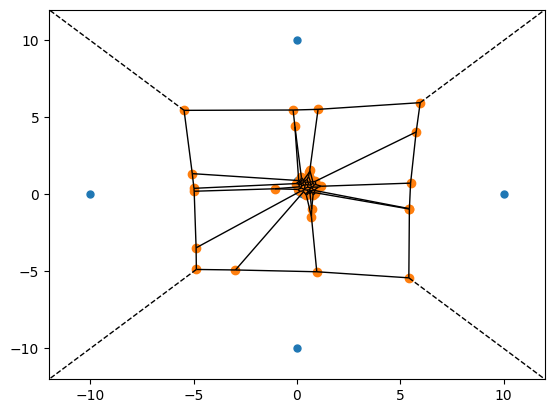

In [371]:
M = 10
# need to add if to compare against original sample length so it doesnt repeatedly add points
Pbound = np.append(P, ([[M,0],[-M,0],[0,M],[0,-M]]), axis=0)

vor = Voronoi(Pbound)
fig = voronoi_plot_2d(vor, point_size=10)

print(vor.ridge_points.shape)
print(vor.ridge_vertices)

# we can use these to find which points have edges,
# print(vor.points)
# print(vor.points[vor.ridge_points])

# print([vor.ridge_vertices])

One observation (true by properties of voronoi diagrams), as long as our bounding box is sufficiently outside (encloses) all our agents, the number of ridge points/verts won't change, so we don't need to worry about finding a "right" bounding box, just a big enough one

Now, we need to see if the line segment between two points intersects with the ridge between them. If it doesn't, then we konw this point will be impacted by the radius-limit.

In [372]:
# voronoi points, our input points + the bounding box
v_p = vor.points
v_rp = vor.ridge_points

# voronoi vertices, the points that compose the ridges
v_v = vor.vertices
v_rv = vor.ridge_vertices

# for an index, print the voronoi points and voronoi vertices that we will use for our intersection
i = 12
# we will set points u and v to these for testing
u = v_p[v_rp[i]]
v = v_v[v_rv[i]]

print(u)
print(v)

print(u[0])

[[10.          0.        ]
 [ 0.93491624  0.73452398]]
[[5.76653986 4.05836141]
 [5.49744217 0.73730842]]
[10.  0.]


In [373]:
# https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
# this code was taken from stack overflow, some ppl said it doesn't deal well with colinearity 
# but that shouldn't be an issue given our setup since all lines either are perpendicular or 
# don't intersect at all

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

print(intersect(u[0],u[1],v[0],v[1]))
# doesnt return true if endpoints intersect
print(intersect([0,0],[0,1],[1,0],[0,1]))

# print(intersect([0,1],[0,-1],[-1,0],[1,0]))

False
False


Now we need a way to compare distances to ridge vertices connecting regions.

In [374]:
# once we know which neighbor we are checking against, we can do the following

P = vor.points

i = 0
j = 1

p1 = P[i]
p2 = P[j]

print('point a at i,', i, p1, 'point b at j:', j, p2)
print(P.shape)
print(vor.point_region.shape)

a = vor.point_region[i]
b = vor.point_region[j]

print('point region for point[i]: ', a)
print('point region for point[j]: ', b)

# voronoi regions at the indices
print(vor.regions[a])
print(vor.regions[b])

# common neighbors
cn = np.intersect1d(vor.regions[a], vor.regions[b])
# should always find 2 points (endpoints of connecting edge)

print(cn)

def dist(a,b):
    return np.sqrt(np.abs(b[1]-a[1])**2 + np.abs(b[0]-a[0])**2)

for i in range(cn.size):
    if(cn[i] != -1):
        print('vert idx:', cn[i])
        v = vor.vertices[cn[i]]
        print('vert @', v)
        print('distance to original vertices, should be the same since its a vor vert')
        print(dist(v,p1))
        print(dist(v,p2))
        print('and they are!!!')

point a at i, 0 [0.32724232 0.99349009] point b at j: 1 [0.68075347 0.06974381]
(54, 2)
(54,)
point region for point[i]:  11
point region for point[j]:  30
[40, 19, 18, 16, 9, 8, 39]
[77, 53, 52, 51, 76]
[]


We can now check neighbor intersections and vertices-radius intersections, so we should be able to reproduce the "r-limited Delaunay" the paper uses. Lets start by doing this for one point and all of its neighbors and then turning that into a function (need to reduce reduncancies)

In [375]:
P = vor.points
V = vor.vertices

rp = vor.ridge_points
rv = vor.ridge_vertices

def point_check(p1, p1_idx, p2, p2_idx, r):
    # indices of regions containing these points
    p1_reg = vor.point_region[p1_idx]
    p2_reg = vor.point_region[p2_idx]

    # common neighbors
    cn = np.intersect1d(vor.regions[p1_reg], vor.regions[p2_reg])

    # if either are out of bound, then were checking boundary points which we dont need to
    # also only need to check distance to 1 point, as they should be (and are) equidistant
    # to the voronoi vertices
    if(cn[0] != -1 and cn[1] != -1):
        v1 = vor.vertices[cn[0]]
        v2 = vor.vertices[cn[1]]
        # print(dist(v1,p1) <= r or dist(v2,p1) <= r)
        return (dist(v1,p1) <= r or dist(v2,p1) <= r)
    return False

# point_check((0,0),(0.5,0.4), 2)

# the bounding box points we added are still last in the list, so we only have to go over n-4 elements of P
print(P)

# now we need to find the neighbors of a point
# unfortunately, the voronoi diagram does not store this information :(
    # oh but they do, thats what ridge_points are, ill circle back around to this

    # this is still true though
# fortunately, our code that checks for intersections can run over each edge pair
# also find neighbors in the process AND we only need to check verts once we 
# have already found these neighboring pairs

### GO OVER ALLLLLLLL OF THE EDGES

# make array of new edges
def rlimit(P,V,r):
    edges = list()
    for i in range(rp.shape[0]):
        u = P[rp[i]]
        v = V[rv[i]]

        # u is now one element of the ridge point array
        # each element in the ridge point array is a pair of points that cross this ridge
        # We need this in order to add edges, and also to check voronoi vertex distances
        u_idx = np.where((P[:,0] == u[0][0]) & (P[:,1] == u[0][1]))[0][0]
        uN_idx = np.where((P[:,0] == u[1][0]) & (P[:,1] == u[1][1]))[0][0]

        # check intersection between the edge formed by the original point u and the midpoint of u and its neighbor
        # and the ridge edge formed connecting these points regions
        # use 2 * r/2 = r to check if points are close enough between points
        if (intersect(u[0],u[1],v[0],v[1]) and (dist(u[0],u[1]) <= 2*r)):
            # add edge
            # print("valid edge brah")
            edges.append((u_idx,uN_idx))
            continue
        else:
            # check neighbor vert in voronoi using r/2 value passed in
            if(point_check(u[0], u_idx, u[1], uN_idx, r) == True):
                # print("valid edge brah")
                edges.append((u_idx,uN_idx))
                continue
        # print("invalid edge brah")
        
    return np.array(edges)

[[  0.32724232   0.99349009]
 [  0.68075347   0.06974381]
 [  0.86938261   0.39994496]
 [  0.13713155   0.75955183]
 [  0.17741174   0.08871464]
 [  0.95467037   0.3131917 ]
 [  0.93491624   0.73452398]
 [  0.02520496   0.84779872]
 [  0.64329673   0.70931043]
 [  0.12438764   0.97424014]
 [  0.83163966   0.09897299]
 [  0.60951257   0.22713237]
 [  0.56608025   0.89145384]
 [  0.47941314   0.14047591]
 [  0.64206641   0.09165035]
 [  0.25264425   0.95110633]
 [  0.18876229   0.90359568]
 [  0.46732994   0.86125205]
 [  0.77011412   0.6200824 ]
 [  0.69852275   0.92692732]
 [  0.11246129   0.3044787 ]
 [  0.22212779   0.82425938]
 [  0.05523545   0.25657586]
 [  0.36795021   0.97115033]
 [  0.28863819   0.55582541]
 [  0.51482468   0.10392829]
 [  0.04214222   0.57579361]
 [  0.86987565   0.72599723]
 [  0.89076589   0.05445969]
 [  0.37317212   0.71815426]
 [  0.79583948   0.94634923]
 [  0.16851232   0.59256651]
 [  0.48023821   0.52880517]
 [  0.29635174   0.01154185]
 [  0.86536203

In [376]:
print('radius =', r)
n_edges = rlimit(P,V,r/2)
print(n_edges.shape)

radius = 0.2
(88, 2)


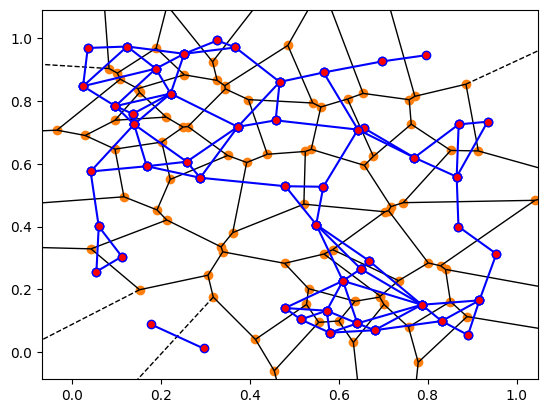

In [391]:
P_noBound = vor.points[0:vor.points.shape[0]-4]

NBvor = Voronoi(P_noBound)
fig = voronoi_plot_2d(NBvor, point_size=10)
plt.plot(P[:,0][n_edges.T], P[:,1][n_edges.T], linestyle='-', color='b',
        markerfacecolor='red', marker='o')

plt.show()

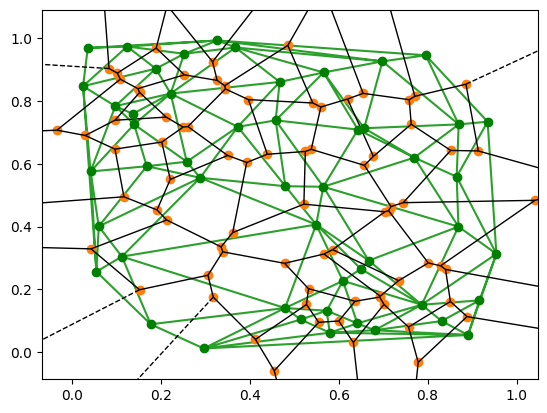

In [400]:
# compare to delaunay
tris = delG(P_noBound)
fig = voronoi_plot_2d(NBvor, point_size=10)
plt.plot(P_noBound[:,0], P_noBound[:,1], 'go')
plt.triplot(P_noBound[:,0], P_noBound[:,1], tris.simplices.copy())